## Framing the research approach

Research Questions: 

- What can smart-meter readings tells me about energy exports to the grid produced by solar panels of a residential home?
- Can I predict grid "feed-in" / energy export of a single residential household at 60-min intervals?
- Can I accurately model the revenue a household generates from "feed-in" tariffs for a coming day by using PV generation, appliance usage and weather data - using a LSMT model?

Assumptions:

- The households don't have PV storage units
- Feed-in tariffs are constant irrespective of time of day and season

### Required Modules

In [94]:
#Import required libraries
import os
import numpy as np
from numpy import split
from numpy import array
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import DataFrame

from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
#from statsmodels.tsa.stattools import adfuller
from math import sqrt
from numpy import split
from numpy import array
from random import gauss

### Import & Clean Data

In [95]:
data = pd.read_csv('household_data_60min_singleindex.csv', sep = ',')
weather_data = pd.read_csv('weather_data.csv', sep = ',')

In [96]:
# filter for residential housing data
residential = ['utc_timestamp'] + [i for i in data.columns if 'DE_KN_residential' in str(i)]
df = data[residential]

# adjust timestamp and make index
pd.to_datetime(df['utc_timestamp']).dt.tz_convert('utc')
df.index = pd.DatetimeIndex(df['utc_timestamp'])
del df['utc_timestamp']

In [97]:
# import weather data
weather_data.index = pd.DatetimeIndex(weather_data['utc_timestamp'])
weather_data = weather_data.drop(columns = ['utc_timestamp'])
weather_ch = weather_data.filter(['CH_temperature', 'CH_radiation_direct_horizontal',	'CH_radiation_diffuse_horizontal'], axis=1)

In [98]:
col_inds = {'DE_KN_residential4_grid_import': [7271,24817],	'DE_KN_residential4_grid_export':[7271,24817],'DE_KN_residential4_pv':[7271,24817],
 'DE_KN_residential4_dishwasher':[7346,19963],	'DE_KN_residential4_washing_machine':[7346,19601],
 'DE_KN_residential4_freezer':[7344,24900], 'DE_KN_residential4_heat_pump':[7271,19582],
 'DE_KN_residential4_refrigerator':[7360,18123]}

# take the first difference of the data to create time series
def time_series(indices:dict):
  for k, v in indices.items():
    df[k][v[0]:v[1]] = df[k][v[0]:v[1]].diff()

time_series(col_inds)
keys = [i for i in col_inds.keys()]

# slice data by time period of interest
df = df[keys][7272:24817] 

/Users/philippeble/mambaforge/envs/gnn_lab/lib/python3.10/site-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._set_values(indexer, value)
/var/folders/mr/d6vcg63j0n715s_t01p_dhxh0000gn/T/ipykernel_8840/576434310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k][v[0]:v[1]] = df[k][v[0]:v[1]].diff()


In [99]:
def fill_hourly_mean (cols):
  for i in cols:
    df[i] = df[i].groupby([df.index.month,df.index.weekday, df.index.hour]).transform(lambda x: x.fillna(max(0, np.random.poisson(x.mean()))))

fill_hourly_mean(keys) 

In [100]:
df_clean = pd.merge(df, weather_ch, left_index=True, right_index=True, how='left')

## High-Level EDA

In [101]:
# rearrange order of datafram e
df_ = df_clean['DE_KN_residential4_grid_import'].values
del df_clean['DE_KN_residential4_grid_import']
df_clean.insert(1, 'DE_KN_residential4_grid_import', df_)
df = df_clean

In [102]:
df.head()

,DE_KN_residential4_grid_export,DE_KN_residential4_grid_import,DE_KN_residential4_pv,DE_KN_residential4_dishwasher,DE_KN_residential4_washing_machine,DE_KN_residential4_freezer,DE_KN_residential4_heat_pump,DE_KN_residential4_refrigerator,CH_temperature,CH_radiation_direct_horizontal,CH_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,
2015-10-10 17:00:00+00:00,0.0,0.823,0.0,0.0,0.0,0.0,0.01,0.0,9.191,0.0023,0.0587
2015-10-10 18:00:00+00:00,0.0,0.755,0.0,1.0,0.0,0.0,0.02,0.0,8.916,0.0000,0.0000
2015-10-10 19:00:00+00:00,0.0,0.355,0.0,0.0,0.0,0.0,0.01,0.0,8.685,0.0000,0.0000
2015-10-10 20:00:00+00:00,0.0,0.327,0.0,0.0,0.0,0.0,0.01,0.0,8.441,0.0000,0.0000
2015-10-10 21:00:00+00:00,0.0,0.200,0.0,0.0,0.0,0.0,0.02,0.0,8.279,0.0000,0.0000


In [91]:
# plot main features to review data quality - skipped
'''plt.figure(figsize=(8,  3* len(df.columns)))

for ind, val in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, ind+1)
    plt.plot(df.index, df[val], label = val)
    plt.legend()'''

'plt.figure(figsize=(8,  3* len(df.columns)))\n\nfor ind, val in enumerate(df.columns):\n    plt.subplot(len(df.columns), 1, ind+1)\n    plt.plot(df.index, df[val], label = val)\n    plt.legend()'

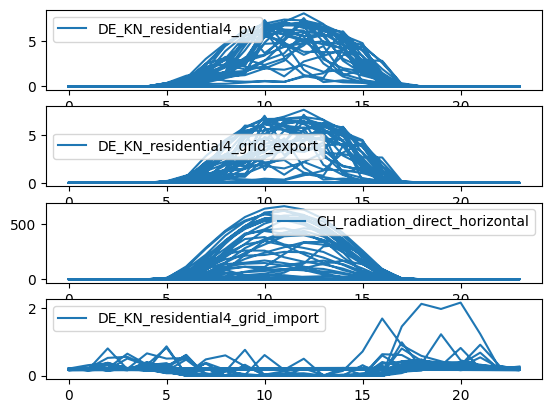

In [103]:
# inspect typical daily patterns of our deatures (based on 1-month period)

cols = ['DE_KN_residential4_pv','DE_KN_residential4_grid_export','CH_radiation_direct_horizontal','DE_KN_residential4_grid_import']

plt.figure()

for ind, val in enumerate(cols):
    plt.subplot(len(cols), 1, ind+1)
    plt.plot(df[val]['2017-09'].index.hour, df[val]['2017-09'], label = val)
    plt.legend()

plt.show()

In [ ]:
# test the correlations of our features

columns = ['Grid_Export','Grid_Import','PV_Production','Dishwasher', 'Washing Machine', 'Freezer' , 'Heat_Pump', 'Refrigerator', 'Temperature', 'Direct_Radiation', 'Diffuse_Radiation']
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
plt.show()

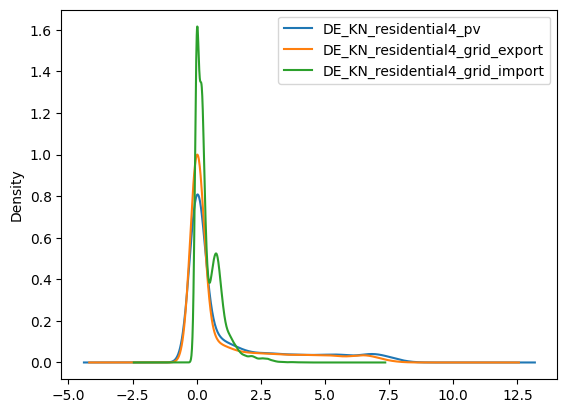

,DE_KN_residential4_grid_export,DE_KN_residential4_grid_import,DE_KN_residential4_pv,DE_KN_residential4_dishwasher,DE_KN_residential4_washing_machine,DE_KN_residential4_freezer,DE_KN_residential4_heat_pump,DE_KN_residential4_refrigerator,CH_temperature,CH_radiation_direct_horizontal,CH_radiation_diffuse_horizontal
count,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000
mean,1.019456,0.452444,1.273947,0.010647,0.012446,0.018238,0.301500,0.017944,8.387009,101.926591,63.619301
std,1.879041,0.533445,2.117172,0.081361,0.094636,0.016140,0.441509,0.083335,7.988948,187.835313,88.771638
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.549000,0.000000,0.000000
25%,0.000000,0.030000,0.000000,0.000000,0.000000,0.015000,0.000000,0.000000,2.306000,0.000000,0.000000
50%,0.000000,0.240000,0.020000,0.000000,0.000000,0.017000,0.000000,0.000000,7.830000,0.465100,6.941600
75%,1.054000,0.726000,1.600000,0.000000,0.000000,0.022000,0.550000,0.023000,14.562000,113.862900,102.439300
max,8.371000,4.898000,8.785000,1.000000,2.000000,1.000000,3.000000,1.000000,28.392000,889.587500,412.057500


In [104]:
# density plot of the highly correlated variables to get a overview of their distribution

df[['DE_KN_residential4_pv','DE_KN_residential4_grid_export','DE_KN_residential4_grid_import']].plot(kind='kde')
plt.show()

df.describe()

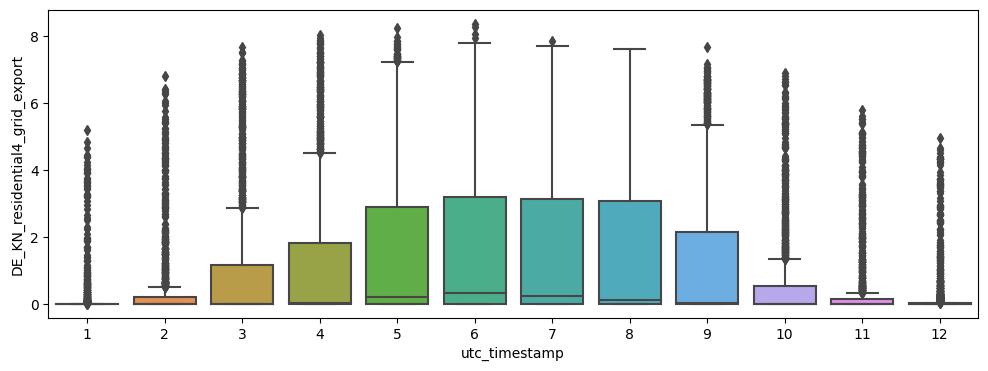

In [105]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x=df.index.month, y='DE_KN_residential4_grid_export', data=df, ax=ax)
plt.show()

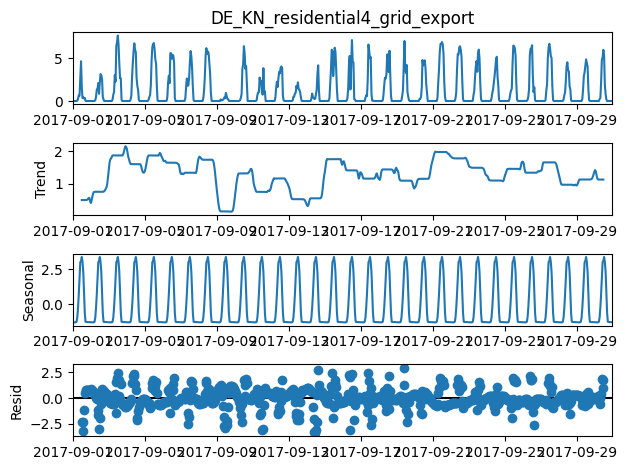

In [110]:
# decompose time series to inspect trend, seasonality and residuals

from statsmodels.tsa.seasonal import seasonal_decompose 

series = df['DE_KN_residential4_grid_export']['2017-09']
result = seasonal_decompose(series, model='additive') 
result.plot()
plt.show()

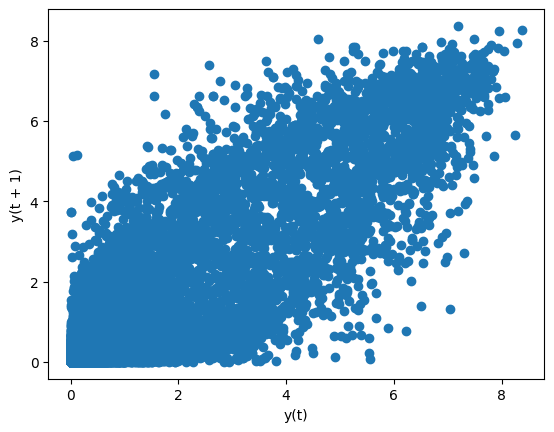

In [111]:
# lag analysis

lag_plot(df['DE_KN_residential4_grid_export'], lag = 1)
plt.show()

/Users/philippeble/mambaforge/envs/gnn_lab/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


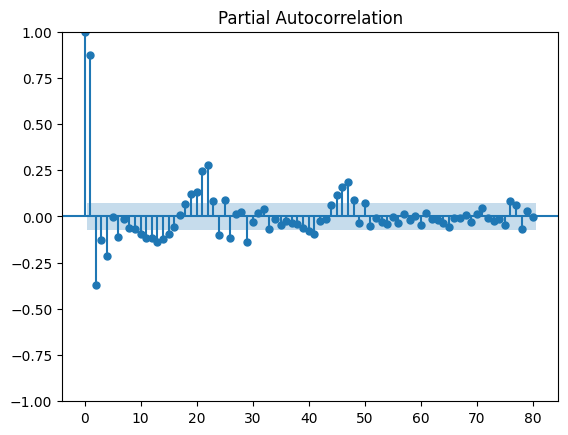

In [112]:
#PACF

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['DE_KN_residential4_grid_export']['2017-09'], lags=80)
plt.show()

## Modelling & Prediction - RNN (Multivariate Long Short Memory Model)

In [116]:
# evaluation function - with the current feed-in price assumption

def revenue_pred(actual, pred):
  comp = 0.0683
  real_rev = sum(i*comp for i in actual)
  pred_rev = sum(max(0,i)*comp for i in pred)
  diff = abs(real_rev - pred_rev)
  return "Absolute residual: %s Euros\nActual value of energy production: %s Euros\nPredicted value of energy production: %s Euros" % (round(diff,2) , round(real_rev,2),round(pred_rev,2))

In [117]:
# take the split train_set and define the number of lag observations as input (X) and the number of observations as output (y)

def supervised_learn(train, n_input, n_out):
	#reshape data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
	X, y = list(), list()
	start = 0
	#move through full training set to create training and validation sequences
	for _ in range(len(data)):
		#define the end of the input sequence
		end = start + n_input
		out_end = end + n_out
		#stop at end of training set
		if out_end <= len(data):
			X.append(data[start:end,:])
			y.append(data[end:out_end, 0])
		#increment starting point
		start += 1
	return array(X), array(y)

# scale and create time series train / validation split
scaler = MinMaxScaler()
train_set = scaler.fit_transform(df)

def create_split_array(data):
  data = data[1:]
  train = array(split(data, 731))
  return train 

#Create 24-hour training sequences
train = create_split_array(train_set)

#Create training and validation variables
n_input = 12 
trainX, trainY = supervised_learn(train, n_input, n_out = 1)

### Build & Train Stacked LSMT Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            19456     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,905
Trainable params: 31,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8


2022-11-10 17:57:58.672405: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


658/658 [==============================] - 7s 7ms/step - loss: 0.0141 - val_loss: 0.0097
Epoch 2/8
658/658 [==============================] - 5s 7ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 3/8
658/658 [==============================] - 5s 7ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 4/8
658/658 [==============================] - 5s 7ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 5/8
658/658 [==============================] - 5s 8ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 6/8
658/658 [==============================] - 5s 7ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 7/8
658/658 [==============================] - 5s 7ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 8/8
658/658 [==============================] - 4s 7ms/step - loss: 0.0063 - val_loss: 0.0070


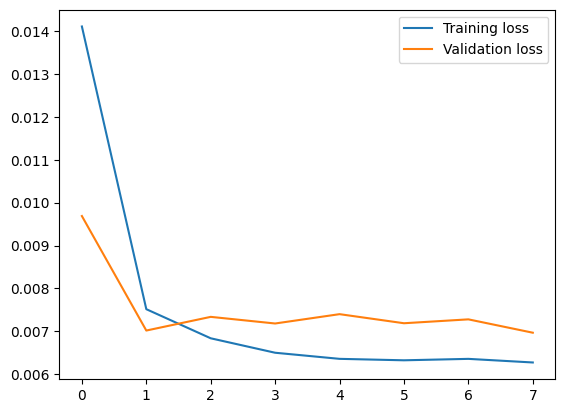

In [118]:
#Build a stacked LSTM model 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

#Fit the model
history = model.fit(trainX, trainY, epochs=8, batch_size=24, validation_split=0.1, verbose=1) #8,3

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Make prediction and plot outcomes

1/1 [==============================] - 0s 263ms/step


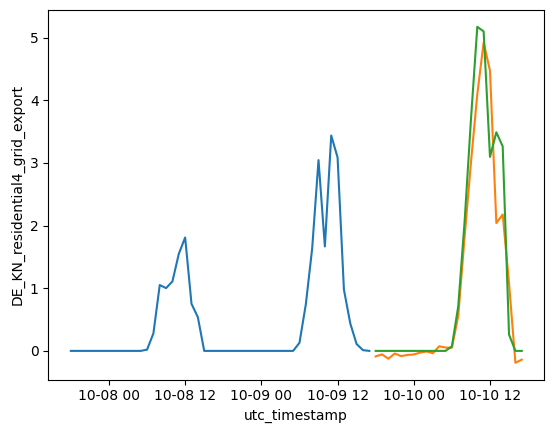

In [119]:
#Create date variables
train_dates = df[1:-24].index
test_dates = df[-24:].index

#Predict 1 (24-hour) period into the future 
n_future = 24
prediction = model.predict(trainX[-n_future:])  

#Transform back to previous scale
prediction_copies = np.repeat(prediction, 11, axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

#Plot last 2 days of test data and actual vs predicted values 
sns.lineplot(x = train_dates[-48:], y = df['DE_KN_residential4_grid_export'][-72:-24].values)
sns.lineplot(x = test_dates, y = y_pred_future)
sns.lineplot(x = test_dates, y = df['DE_KN_residential4_grid_export'][-24:])

plt.show()

### Evaluation Summary

In [129]:
 actual = df['DE_KN_residential4_grid_export'][-24:].values

print("RSME:%s" % round(sqrt(mean_squared_error(actual, y_pred_future)),3))
print(revenue_pred(actual,y_pred_future))


RSME:0.566
Absolute residual: 0.18 Euros
Actual value of energy production: 1.84 Euros
Predicted value of energy production: 1.66 Euros


### Residual Analysis

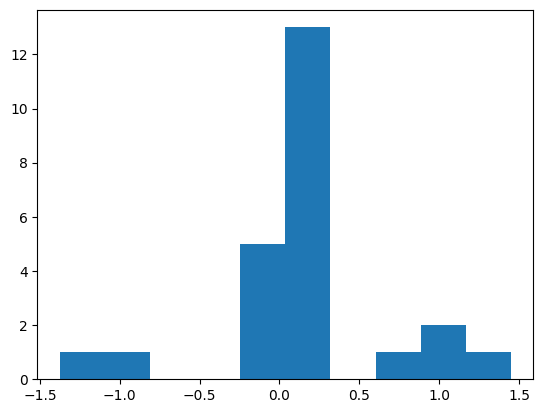

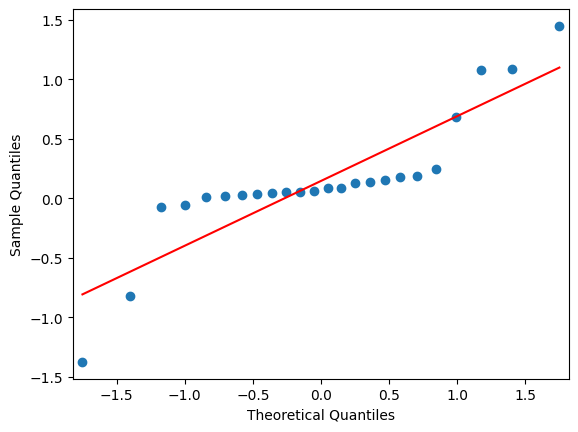

In [123]:
from statsmodels.graphics.gofplots import qqplot

#Plot histogram
plt.hist(actual - y_pred_future)

#Plot theoretical quantiles of a normal distribution 
qqplot(actual - y_pred_future, line='r')

plt.show()

## Conclusions

### Research Outcomes:

- Question 1: Smart meter readings can help elucidate the relationship between PV production and household exports to grids.
- Question 2 + 3: Yes, we can predict grid feed-in and potentially with a good approximation of the revenue a household could produce for the next 24 hours. 


### Limitations:

- Weather data is used for Switzerland. Data on more proximite areas would have been preferred.


### Potentials next steps:

- To operationalise this approach for longer periods, by using a "sliding window" forward validation approach to train the model with new information on a daily, weekly or monthly basis. 

- Work on predicting subsets (e.g. different times of the day) 

- Evaluate the model on a longer period and / or at different months of the year